In [1]:
import os
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from segmentation_models import get_preprocessing
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [2]:
DATA_PATH = "/Users/acabrera/dev/data/sessile-main-Kvasir-SEG"
BACKBONE = 'resnet18'
preprocess_input = get_preprocessing(BACKBONE)

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

class Dataset: 
    def __init__(
            self, 
            dir,
            preprocessing=None,
    ):
        images_dir = os.path.join(dir, "images")
        masks_dir = os.path.join(dir, "masks")
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] 
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        image = cv2.resize(image, (224, 224))
        mask = cv2.resize(mask, (224, 224))

        mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)[1]
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)

        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        # if mask.shape[-1] != 1:
        #     background = 1 - mask.sum(axis=-1, keepdims=True)
        #     mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        # if self.augmentation:
        #     sample = self.augmentation(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            image = self.preprocessing(image)
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [4]:
dataset = Dataset(DATA_PATH, preprocessing=preprocess_input)

In [5]:
ids = ["images/" + idx for idx in dataset.ids]
labels = ["masks/" + idx for idx in dataset.ids]

In [6]:
df = pd.DataFrame({"id": ids, "label": labels})

In [ ]:
df.to_csv('segmentation.csv', index=False)

In [ ]:
image, mask = dataset[2] # get some sample
visualize(image=image, mask=mask[..., 0])

In [11]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

In [8]:
model = sm.Unet(BACKBONE)

2022-07-21 10:37:46.209213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [10]:
train_dataloader = Dataloder(dataset, batch_size=BATCH_SIZE, shuffle=True)
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [14]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=10, 
    callbacks=callbacks, 
)

/var/folders/tq/kqg2ct9d123gd0wmshf2bd3r0000gp/T/ipykernel_86993/1839238397.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
24/24 [==============================] - 100s 4s/step - loss: 0.0942 - iou_score: 0.9251 - lr: 1.0000e-04
Epoch 2/10
24/24 [==============================] - 104s 4s/step - loss: 0.0877 - iou_score: 0.9304 - lr: 1.0000e-04
Epoch 3/10
24/24 [==============================] - 91s 4s/step - loss: 0.0847 - iou_score: 0.9303 - lr: 1.0000e-04
Epoch 4/10
24/24 [==============================] - 105s 4s/step - loss: 0.0798 - iou_score: 0.9338 - lr: 1.0000e-04
Epoch 5/10
24/24 [==============================] - 102s 4s/step - loss: 0.0772 - iou_score: 0.9341 - lr: 1.0000e-04
Epoch 6/10
24/24 [==============================] - 102s 4s/step - loss: 0.0735 - iou_score: 0.9362 - lr: 1.0000e-04
Epoch 7/10
24/24 [==============================] - 101s 4s/step - loss: 0.0716 - iou_score: 0.9357 - lr: 1.0000e-04
Epoch 8/10
24/24 [==============================] - 110s 5s/step - loss: 0.0691 - iou_score: 0.9372 - lr: 1.0000e-04
Epoch 9/10
24/24 [==============================] - 106s 4s/step 

In [ ]:

n = 5
ids = np.random.choice(np.arange(len(dataset)), size=n)

for i in ids:
    
    image, gt_mask = dataset[i]
    image = np.expand_dims(image, axis=0)
    print(image.shape)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [15]:
model.save_weights('weights.ckpt')

In [ ]:
loaded_model = sm.Unet(BACKBONE)

In [ ]:
loaded_model.load_weights('weights.ckpt')

1/1 [==============================] - 4s 4s/step


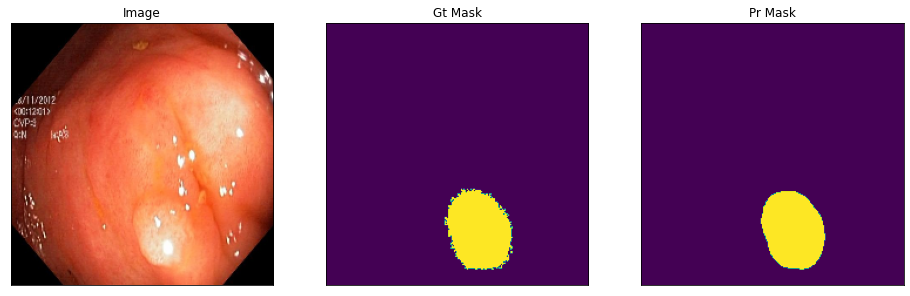

1/1 [==============================] - 0s 172ms/step


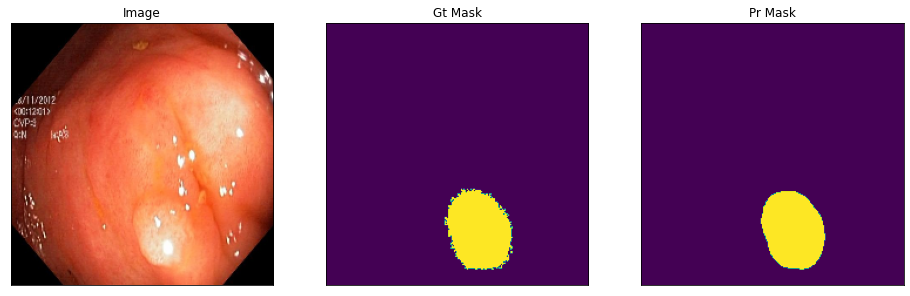

1/1 [==============================] - 0s 160ms/step


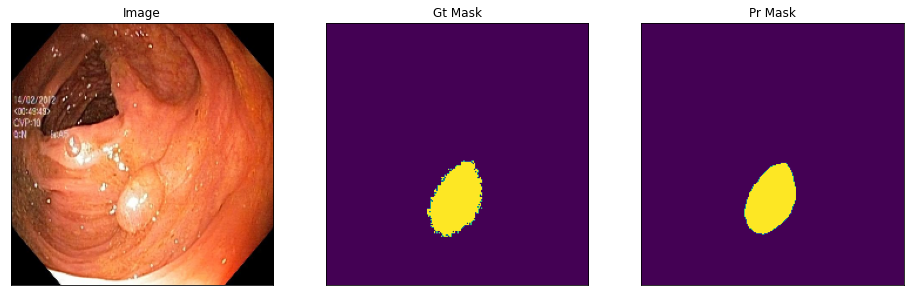

1/1 [==============================] - 0s 148ms/step


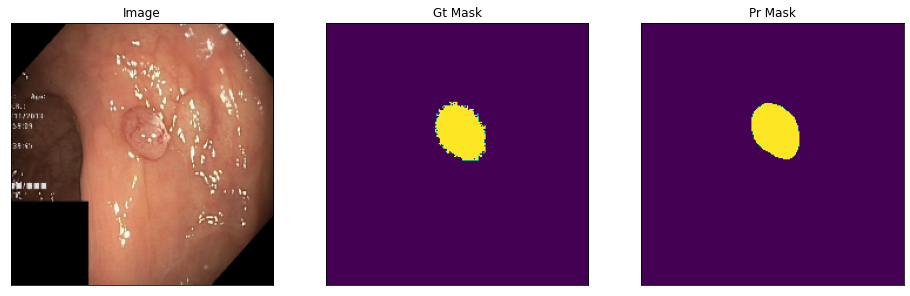

1/1 [==============================] - 0s 171ms/step


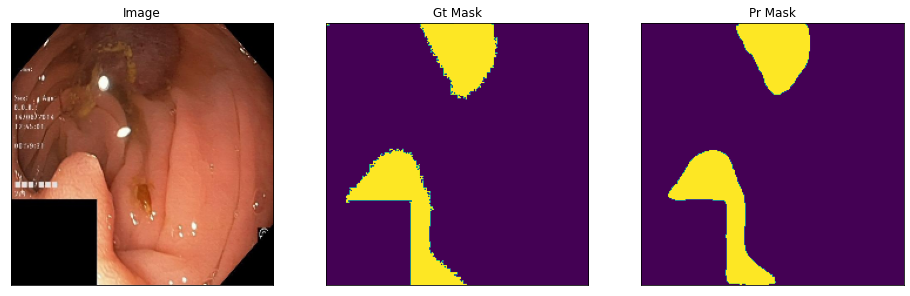

In [17]:

n = 5
ids = np.random.choice(np.arange(len(dataset)), size=n)

for i in ids:
    
    image, gt_mask = dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
dataset[3][0][20:50, 20:50, 0]